# Фитирование данных в работе 6.1 "Эффект Мёссбауэра" 

Импортируем библиотеки, которые потребуются по ходу работы

In [137]:
from scipy.optimize import basinhopping
import numpy as np
import random
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from datetime import datetime

## Функции для оптимизации

Минимизировать будем сумму квадратов отклонений с учётом погрешностей. Запишем функцию, которая по данной выборке, погрешностям в ней и предсказаниям нашей модели на этих данных возвращает взвешенную сумму квадратов отклонений. Будем предполагать, что значения распределены нормально со средним в значении из выборки и с дисперсией, равной квадрату погрешности точки (помним о том, что дисперсия - средний *квадрат* отклонения). В таком случае статистика учит нас, что в качестве весов точек нужно использовать обратные дисперсии - обратные квадраты погрешностей. 

In [138]:
def sum_sq_dev(y, yerr, predictions): #Иксы не нужны, нужны только их погрешности - они влияют на вес точек
    res = 0.
    for i in range(len(y)):
        res += (y[i]-predictions[i])**2#/yerr[i]**2 (не нужно, если погрешности точек одинаковы)
    return res

Данные будут фитироваться следующей зависимостью: 
$$I(v)(b,c,d,I_0,I_1) = I_1+I_0 \int_{-\infty}^{\infty}\dfrac{e^{-\dfrac{b}{1+t^2}}}{1+(t-cv+d)^2}dt$$
Для подсчёта интеграла будем пользоваться методом из стандартной библиотеки. 

In [139]:
def I(v,b,c,d,I0,I1):#А теперь вычислим, собственно, саму функцию
    return list(map(lambda x: I1+I0*(integrate.quad(lambda t: np.exp(-b/(1+t**2))/(1+(t-c*x+d)**2), -500, 500)[0]), v))

Теперь создадим оптимизатор, который по заданной выборке подбирает искомые параметры $b,c,d,I_0, I_1$. Как показала практика авторов работы, быстрее и устойчивее других алгоритмов на наших выборках работает дифференциальная эволюция. Это метод глобальной оптимизации. Методы глобальной оптимизации даже при неплохих начальных условяих склонны на наших данных застревать в локальных минимумах.

In [140]:
def optimizer(x, y, yerr,params_bounds):#Зависимость - I(v), поэтому x - v
    return opt.differential_evolution(lambda params: sum_sq_dev(y,yerr,I(x,params[0],params[1],params[2],params[3],params[4])),params_bounds)

Методы глобально оптимизации, как приведённый выше, работают долго, но зато сходятся к глоабльному минимуму. Чтобы ускорить поиск минимума, можно пользоваться локальными методами оптимизации, если мы уверены, что в окрестности начального приближения находится глобальный минимум. Задача скорее всего довольно гладкая и с небольшим числом параметров, поэтому применим BFGS.

In [141]:
def fast_optimizer(x,y,yerr,initial_params):#Чтобы метод сошёлся куда нужно, стоит задать хорошие начальные параметры вручную
    return opt.minimize(lambda params: sum_sq_dev(y,yerr,I(x,params[0],params[1],params[2],params[3],params[4])), initial_params,  method = "BFGS")

## Подсчёт погрешности

Используем довольно ресурсозатратный, но простой в осмыслении и реализации метод. 
Будем генерировать несколько (например, 5) выборок, которые отличаются от данной "в пределах погрешности". Т.е. будем каждую точку заново выбирать из гауссова распределения с максимумом в этой точке и дисперсией равной квадрату погрешности.
Затем можно на каждой новой выборке с помощью быстрой локальной оптимизации находить новый оптимум параметров и в конечном счёте считать дисперсии полученных значений параметров по полученным нескольким их значениям.
Заметим, что такой метод предполагает отсутствие в данной области нескольких минимумов. Чтобы учесть и такую возможность, оптимизацию лучше использовать глобальную. А чтобы её ускорить, можно задать искусственно хорошие начальные границы области параметров. Кроме того, практика показала, что у методов локальной оптимизации в нашей задаче возникают проблемы со сходимостью.

In [142]:
def params_range(x,y,xerr,yerr,opt_params,N = 5, scale_to_search = 0.5):
    x_arrs = np.ones(N*len(x))
    x_arrs = np.reshape(x_arrs,(N,len(x)))
    for i in range(N):
        for j in range(len(x)):
            x_arrs[i][j] = random.gauss(x[j], xerr[j])
    y_arrs = np.ones(N*len(y))
    y_arrs = np.reshape(y_arrs,(N,len(y)))
    for i in range(N):
        for j in range(len(y)):
            y_arrs[i][j] = random.gauss(y[j], yerr[j])
    params_arr = np.ones(N*len(opt_params))
    params_arr = np.reshape(params_arr,(N,len(opt_params)))
    params_bounds = np.ones(2*len(opt_params))
    params_bounds = np.reshape(params_bounds,(len(opt_params),2))
    for i in range(len(opt_params)):
        params_bounds[i][0] = opt_params[i]-opt_params[i]*scale_to_search
        params_bounds[i][1] = opt_params[i]+opt_params[i]*scale_to_search
    for i in range(N):
        params_arr[i] = optimizer(x_arrs[i], y_arrs[i], yerr,params_bounds).x
        print(i," : ", params_arr[i])
    return params_arr #Будем возвращать не погрешности параметров, а сами наборы параметров для гибкости в дальнейшем анализе

### Вся обработка в одной функции

Теперь соединим подсчёт погрешностей и оптимизацию в одну большую функцию, которую потом просто будем применять к данным. Кроме того, хотелось бы, чтобы эта функция строила итоговый график с доверительным интервалом, в котором лежат предсказываемые значения функции.
Чтобы решить последнюю задачу будем в каждой точке x искать максимальное и минимальное значение функции I. Делать это будем по полученным наборам парамтров при подсчёте погрешности. Так как значений будет не так много, оценки на min и max будут завышенными и заниженными соответственно. Чтобы это компенсировать, увеличим в несколько раз разницу между средним и минимальным, как и между средним и максимальным. Всё это, конечно, эвристические оценки, но наглядное представление о полученной аппроксимации они дадут более хорошее. Опытным путем был подобран коэффициент 5 увеличения разницы.

In [143]:
def minI3(v,params_arr,opt_params,N): #Находит минимальное значение интеграла при данных параметрах 
    res = np.ones(len(v))           #и отклоняет значение в 5 раз ниже данного от оптимального (см комментарий выше)
    for j in range(len(v)):
        I_opt = I([v[j]],*opt_params)[0]
        I_res = I_opt
        for i in range(len(params_arr)):
            params_i = params_arr[i]
            Inew = I([v[j]],*params_i)[0]
            if Inew < I_res:
                I_res = Inew
        diff = I_opt-I_res
        res[j] = I_opt-N*diff
    return res
def maxI3(v,params_arr,opt_params,N): #то же, но про максимальное значение
    res = np.ones(len(v))
    for j in range(len(v)):
        I_opt = I([v[j]],*opt_params)[0]
        I_res = I_opt
        for i in range(len(params_arr)):
            params_i = params_arr[i]
            Inew = I([v[j]],*params_i)[0]
            if Inew > I_res:
                I_res = Inew
        diff = I_res-I_opt
        res[j] = I_opt+N*diff
    return res
def big_plot(x,y,xerr,yerr,opt_params,params_arr): #отрисовывает график оптимальных параметров,область вариации параметров
    plt.figure(figsize=(10,7))                     #и кресты погрешности
    plt.errorbar(x, y, xerr=xerr*3, yerr=yerr*3, fmt='m,', ecolor='lightgray')
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='m,', ecolor='k')
    plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),I(np.arange(min(x)-0.2,max(x)+0.2,0.1),*opt_params),'r')
    plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),minI3(np.arange(min(x)-0.2,max(x)+0.2,0.1),params_arr,opt_params,3),'gray')
    plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),maxI3(np.arange(min(x)-0.2,max(x)+0.2,0.1),params_arr,opt_params,3),'gray')
    plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),minI3(np.arange(min(x)-0.2,max(x)+0.2,0.1),params_arr,opt_params,5),'lightgray')
    plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),maxI3(np.arange(min(x)-0.2,max(x)+0.2,0.1),params_arr,opt_params,5),'lightgray')
    return
def data_processing(x,y,xerr,yerr):
    opt_params =  optimizer(x, y, yerr,[(0,10),(-10,10),(-12,17),(-1000,10000),(-1000,10000)]).x #[  2.12605954,  -3.81650946,  -9.37962983, 226.62393565,
           #937.04568283]
    print(opt_params)
    params_arr =  params_range(x, y, xerr,yerr,opt_params,5)#[[   2.81166241,   -4.33344289,  -10.67169402,  204.72541677,
           # 1001.86787128],
          #[   2.55337753,   -3.95299098,   -9.69176832,  210.07824275,
          #   988.52666358]] 
    big_plot(x,y,xerr,yerr,opt_params,params_arr)
    errors_arr = np.zeros(len(opt_params))
    for i in range(len(opt_params)):
        param_i_list = np.zeros(1+len(params_arr))
        param_i_list[0] = opt_params[i]
        for j in range(len(params_arr)):
            param_i_list[j+1] = params_arr[j][i]
        errors_arr[i] = np.sqrt(np.var(param_i_list))
    return opt_params, errors_arr, params_arr

## Обработка данных

Отлично. Теперь будем обрабатывать данные. Для начала подгрузим их.
Так как обработка происходит долго, во всех случаях, кроме $H=90$, данные обрабатывались на другом компьютере и поэтому графики строятся по ним. Чтобы обработать данные на своём компьютере - нужно убрать комментирование из соответствующих ячеек с кодом.

In [144]:
data = pd.read_excel('data.xlsx') 

### Sn, H = 310мм

По исходным данным смотрим погрешность Iexp - она равна вариации I на бесконечности. В данном случае 8. Погрешность определения скорости полагаем равной 0,01 мм/с.

In [145]:
v310 = list(data.iloc[:,2])
Iexp310 = list(data.iloc[:,3])

In [146]:
#res310 = data_processing(v310,Iexp310,np.ones(len(v310))*0.01,np.ones(len(v310))*8)

In [147]:
#f = open("310v2.txt", "w")
#print(res310, file=f)
#f.close()

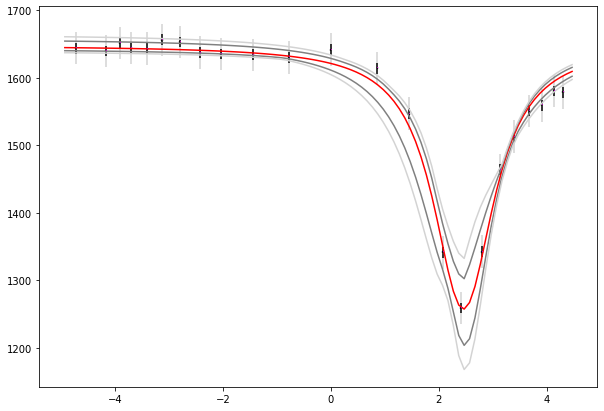

In [148]:
big_plot(v310,Iexp310,np.ones(len(v310))*0.01,np.ones(len(v310))*8,[  2.38633979,  -3.91987004,  -9.63351545, 215.04809079,
       973.32775581],[[   2.71139235,   -3.95846595,   -9.70371402,  203.61897736,
        1010.47411275],
       [   2.10774722,   -3.87865175,   -9.59983522,  227.05678578,
         934.28980456],
       [   3.03498823,   -4.06807398,  -10.01363362,  193.71250794,
        1041.68698048],
       [   3.06451083,   -4.18607011,  -10.3146028 ,  195.27629072,
        1037.27904586],
       [   3.57496949,   -4.28860558,  -10.47508572,  185.99506592,
        1065.27544268],
       [   1.35152994,   -3.64977066,   -9.00559281,  300.44656705,
         703.78847031],
       [   1.31863519,   -3.21168303,   -7.76851093,  284.00399048,
         758.50097748],
       [   2.49890473,   -3.86673448,   -9.50911617,  205.63349985,
        1003.7259386 ],
       [   2.12383464,   -3.90889848,   -9.65300264,  225.1513619 ,
         940.18529333],
       [   2.13917883,   -3.69203116,   -9.10573411,  219.14837483,
         963.81649958]])

### $Sn, H = 180мм$

По исходным данным смотрим погрешность Iexp - она равна вариации I на бесконечности. В данном случае 14. Погрешность определения скорости полагаем равной 0,01 мм/с.

In [150]:
v180 = list(data.iloc[:,4])
Iexp180 = list(data.iloc[:,5])

In [151]:
#res180 = data_processing(v180,Iexp180,np.ones(len(v180))*0.01,np.ones(len(v180))*14)

In [149]:
#f = open("180.txt", "w")
#print(res180, file=f)
#f.close()

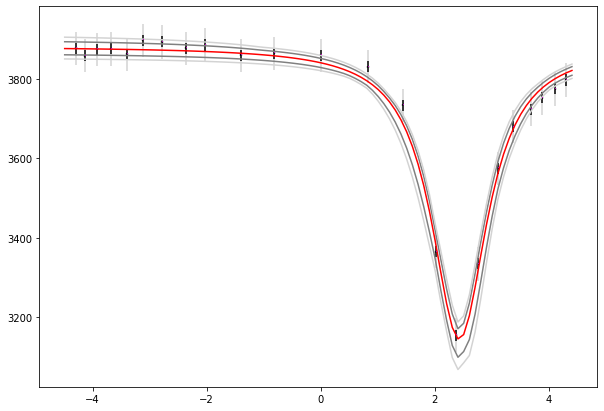

In [152]:
big_plot(v180,Iexp180,np.ones(len(v180))*0.01,np.ones(len(v180))*14,[ 1.09244572e+00, -3.85545241e+00, -9.38134068e+00,  6.23228408e+02,
        1.92652333e+03],[[ 1.01764799e+00, -3.82018714e+00, -9.26398867e+00,
         6.51067981e+02,  1.84165278e+03],
       [ 1.33902574e+00, -3.99906702e+00, -9.74575928e+00,
         5.45128458e+02,  2.16796944e+03],
       [ 1.56668810e+00, -4.12871448e+00, -1.00729481e+01,
         5.00291194e+02,  2.30684248e+03],
       [ 1.58679077e+00, -4.09439184e+00, -1.00382837e+01,
         5.02368704e+02,  2.30619657e+03],
       [ 8.61670539e-01, -3.89545835e+00, -9.45327414e+00,
         7.48104915e+02,  1.53285192e+03],
       [ 7.93347646e-01, -3.50400053e+00, -8.50545462e+00,
         7.78169803e+02,  1.44680113e+03],
       [ 6.50666750e-01, -3.57576132e+00, -8.75176610e+00,
         9.02989264e+02,  1.04981225e+03],
       [ 1.54314246e+00, -4.06564320e+00, -9.88749564e+00,
         5.07993928e+02,  2.29096109e+03],
       [ 1.36265071e+00, -3.99153161e+00, -9.72433696e+00,
         5.51316626e+02,  2.15608639e+03],
       [ 1.38836042e+00, -3.99368959e+00, -9.67111359e+00,
         5.37756232e+02,  2.19200519e+03]])

### $Sn, H = 90мм$

По исходным данным смотрим погрешность Iexp - она равна вариации I на бесконечности. В данном случае 22. Погрешность определения скорости полагаем равной 0,01 мм/с.

In [112]:
v90 = list(data.iloc[:,6])
Iexp90 = list(data.iloc[:,7])

In [154]:
#res90 = data_processing(v90,Iexp90,np.ones(len(v90))*0.01,np.ones(len(v90))*22)

In [155]:
#f = open("90.txt", "w")
#print(res90v2, file=f)
#f.close()

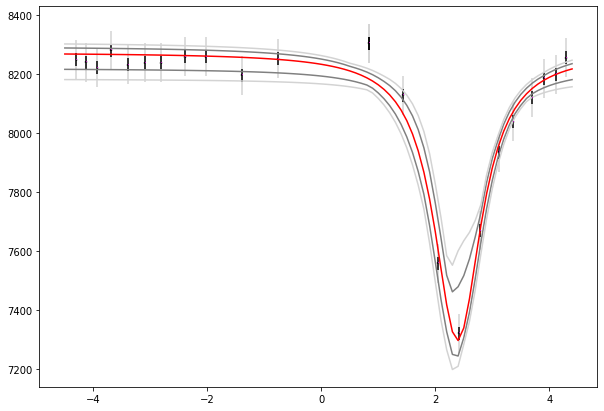

In [153]:
big_plot(v90,Iexp90,np.ones(len(v90))*0.01,np.ones(len(v90))*22,[ 1.88061365e+00, -5.01904297e+00, -1.20000000e+01,  5.98755769e+02,
        6.39354020e+03],[[ 2.63725111e+00, -5.60398444e+00, -1.33914691e+01,
         5.02095197e+02,  6.68211239e+03],
       [ 2.71656895e+00, -5.34470260e+00, -1.28074089e+01,
         5.10358269e+02,  6.67361548e+03],
       [ 2.74491265e+00, -5.55380526e+00, -1.32168922e+01,
         5.14739264e+02,  6.65380283e+03],
       [ 1.90926881e+00, -5.10279827e+00, -1.22588390e+01,
         5.83404568e+02,  6.44350847e+03],
       [ 2.79787265e+00, -5.44987353e+00, -1.30047897e+01,
         5.10065240e+02,  6.67872982e+03],[ 1.90745501e+00, -5.01937213e+00, -1.20000000e+01,  5.93678125e+02,
        6.40958500e+03],[ 2.82330106e+00, -5.10415324e+00, -1.21236645e+01,
         4.71444624e+02,  6.79387923e+03],
       [ 1.59546431e+00, -5.11578233e+00, -1.22628056e+01,
         6.37148145e+02,  6.25519551e+03],
       [ 2.82820984e+00, -5.44751614e+00, -1.29426349e+01,
         5.02606408e+02,  6.69175516e+03],
       [ 2.41385748e+00, -5.49798977e+00, -1.32308946e+01,
         5.33310844e+02,  6.59713671e+03],
       [ 2.26733127e+00, -5.32825356e+00, -1.27687466e+01,
         5.46815821e+02,  6.55853756e+03]])

### $SnO_2$

По исходным данным смотрим погрешность Iexp - она равна вариации I на бесконечности. В данном случае 24. Погрешность определения скорости полагаем равной 0,01 мм/с.

In [157]:
vsn02 = list(data.iloc[:,0])
Iexpsn02 = list(data.iloc[:,1])

In [159]:
#ressn02 = data_processing(vsn02,Iexpsn02,np.ones(len(vsn02))*0.01,np.ones(len(vsn02))*24)

In [160]:
#f = open("sn02.txt", "w")
#print(ressn02, file=f)
#f.close()

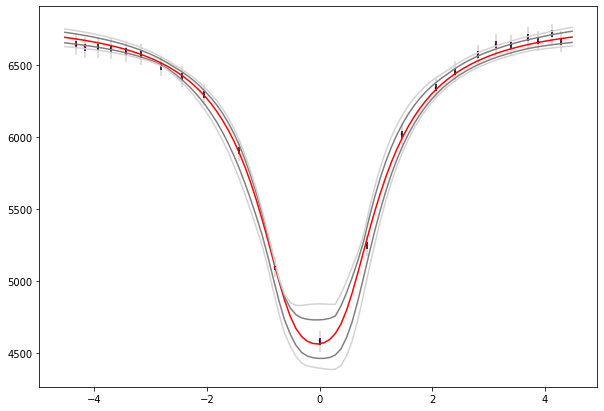

In [158]:
big_plot(vsn02,Iexpsn02,np.ones(len(vsn02))*0.01,np.ones(len(vsn02))*24,[ 2.00000000e+01, -5.04235778e+00,  2.06703240e-01,  8.22341813e+02,
        4.23562116e+03],[[ 2.96735822e+01, -6.07207234e+00,  1.75047092e-01,
         8.11932298e+02,  4.26611175e+03],
       [ 2.93236965e+01, -6.03854464e+00,  3.08458786e-01,
         7.97762779e+02,  4.30021676e+03],
       [ 2.99775219e+01, -5.98860787e+00,  2.99080936e-01,
         8.02140030e+02,  4.30563033e+03],
       [ 2.79986395e+01, -5.70860024e+00,  2.46123274e-01,
         7.88732964e+02,  4.35488440e+03],
       [ 2.98652393e+01, -6.03479972e+00,  3.08577342e-01,
         8.06484819e+02,  4.29245699e+03],
       [ 2.96907254e+01, -6.18235988e+00,  2.80538838e-01,
         8.00616351e+02,  4.28298812e+03],
       [ 2.99850293e+01, -6.07917553e+00,  1.36690460e-01,
         8.04151690e+02,  4.28088135e+03],
       [ 2.94934687e+01, -6.01252772e+00,  2.07246798e-01,
         7.92147145e+02,  4.32660280e+03],
       [ 1.60359762e+01, -4.41586010e+00,  2.55594983e-01,
         8.34778013e+02,  4.21875366e+03],
       [ 2.92732452e+01, -6.17502719e+00,  3.08298459e-01,
         7.98484033e+02,  4.29129280e+03]])